In [427]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import random
import numba as nb
from numba.experimental import jitclass
from numba import types,typed, typeof
from numba import int32, float32    # import the types
import data_visualization as dv
wheel = dv.ColorWheel()

## Helper Functions

In [452]:
@nb.njit
def simulation_runs(NUM_TRIALS, TRIAL_TIME, m, n, player_decision_times, agent_decision_times,
                    reaction_times, movement_times, AGENT_MOVEMENT_TIME):
    if True: # Initialize arrays
        player_wins = np.zeros((m, n))
        player_reaction_wins = np.zeros((m, n))
        player_gamble_wins = np.zeros((m, n))
        
        player_incorrects = np.zeros((m, n))
        player_reaction_incorrects = np.zeros((m, n))
        player_gamble_incorrects = np.zeros((m, n))
        
        player_indecisions = np.zeros((m, n))
        player_reaction_indecisions = np.zeros((m, n))
        player_gamble_indecisions = np.zeros((m, n))
        
        player_decision_array = np.empty((m, n, NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
        agent_decision_array = np.empty((m, n, NUM_TRIALS))
        
        player_reach_times = np.empty((m, n, NUM_TRIALS))
        player_leave_target_times = np.empty((m, n, NUM_TRIALS))
        agent_reach_times = np.empty((m, n, NUM_TRIALS))
    
    for i in range(m):
        for j in range(n):
            for k in range(NUM_TRIALS):
                # For gambles, reach time is decision time + movement time.. this get's overwritten for reaction if statement
                # LEave target time is player decision time for gambles, again get's changed in first if statement
                player_leave_target_times[i,j,k] = player_decision_times[i,j,k]
                player_reach_times[i,j,k] = player_decision_times[i,j,k] + movement_times[i,j,k]
                agent_reach_times[i,j,k] = agent_decision_times[i,j,k] + AGENT_MOVEMENT_TIME
                
                if ((player_decision_times[i,j,k] >= agent_decision_times[i,j,k])): # If player selects after agent, they are forced to react
                    player_leave_target_times[i,j,k] = agent_decision_times[i,j,k] + reaction_times[i,j,k] # PLayer can immediately react to the agent
                    player_reach_times[i,j,k] = player_leave_target_times[i,j,k] + movement_times[i,j,k]
                    if player_reach_times[i,j,k] < TRIAL_TIME:
                        player_wins[i,j] += 1
                        player_reaction_wins[i,j] += 1
                        player_decision_array[i,j,k] = 1
                        agent_decision_array[i,j,k] = -1
                        
                    else: # Player doesn't make it
                        player_indecisions[i,j]+=1
                        player_reaction_indecisions[i,j]+=1
                        player_decision_array[i,j,k] = 0
                        agent_decision_array[i,j,k] = 1
                        if agent_decision_times[i,j,k] + AGENT_MOVEMENT_TIME > TRIAL_TIME: # Agent doesn't make it either
                            agent_decision_array[i,j,k] = 0
                # NO sensory evidence was used---------------------------------
                # Both made it
                elif(player_reach_times[i,j,k] < TRIAL_TIME and 
                    agent_reach_times[i,j,k] < TRIAL_TIME):
                    rand = random.random()
                    
                    if rand>=0.5:
                        player_wins[i,j] += 1
                        player_gamble_wins[i,j] += 1
                        player_decision_array[i,j,k] = 1
                        agent_decision_array[i,j,k] = -1
                    if rand<0.5:
                        player_incorrects[i,j] += 1
                        player_gamble_incorrects[i,j] += 1
                        player_decision_array[i,j,k] = -1
                        agent_decision_array[i,j,k] = 1
                # Player didn't make it, agent did
                elif(player_reach_times[i,j,k]>=TRIAL_TIME and 
                    agent_reach_times[i,j,k]<TRIAL_TIME):
                    player_indecisions[i,j] += 1
                    player_gamble_indecisions[i,j]+=1
                    player_decision_array[i,j,k] = 0
                    agent_decision_array[i,j,k] = 1
                # Agent didn't make it, player did
                elif(player_reach_times[i,j,k]<TRIAL_TIME and 
                    agent_reach_times[i,j,k]>=TRIAL_TIME):
                    player_wins[i,j] += 1
                    player_gamble_wins[i,j]+=1
                    player_decision_array[i,j,k] = 1
                    agent_decision_array[i,j,k] = 0
                # Both didn't make it
                elif(player_reach_times[i,j,k]>TRIAL_TIME and 
                    agent_reach_times[i,j,k]>TRIAL_TIME):
                    player_indecisions[i,j] += 1
                    player_gamble_indecisions[i,j]+=1
                    player_decision_array[i,j,k] = 0
                    agent_decision_array[i,j,k] = 0
                else:
                    print('ERROR NO IF STATEMENT TRIGGERED')
    return player_wins, player_reaction_wins ,player_gamble_wins, player_incorrects ,\
            player_reaction_incorrects, player_gamble_incorrects ,player_indecisions, player_reaction_indecisions, \
            player_gamble_indecisions,player_decision_array, agent_decision_array, player_reach_times,\
            player_leave_target_times, agent_reach_times

def _plot_optimals_all_on_one(self,metrics_ax1,metrics_ax2,save=False):
    fig,ax = plt.subplots(dpi=125)
    color_dict = {'Wins':wheel.dark_blue,'Indecisions':wheel.light_blue,'Incorrects':wheel.blue,
                  'Mean Leave Target Time':wheel.dark_red}
    legend_labels = []
    legend_colors = []
    for i,metric in enumerate(metrics_ax1):
        ax.plot(self.agent_decision_means,self.final_optimal_results_dict[metric],'-o', c = color_dict[metric])
        legend_colors.append(color_dict[metric])
        legend_labels.append(metric)
    # ax.plot(self.agent_decision_means,self.final_optimal_results_dict['Wins'],'-o', c = wheel.light_blue, label = 'Wins')
    # ax.plot(self.agent_decision_means,self.final_optimal_results_dict['Incorrects'],'-o', c = wheel.blue, label = 'Incorrects')
    ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
    
    ax.set_ylim(-5,105)
    ax.set_yticks(np.arange(0,110,10),np.arange(0,110,10),c = wheel.dark_blue)
    ax.set_xlabel("Agent Mean Movement Onset Time")
    ax.set_ylabel(' Percentages (%)')
    ax.spines['left'].set_color(wheel.dark_blue)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_visible(False)

    ax2 = ax.twinx()
    for i,metric in enumerate(metrics_ax2):
        ax2.plot(self.agent_decision_means,self.final_optimal_results_dict[metric],'-o', c=color_dict[metric])
        legend_colors.append(color_dict[metric])
        legend_labels.append(metric)
    ax2.set_yticks(np.arange(400,1600,100))
    ax2.set_yticklabels(np.arange(400,1600,100),c=wheel.dark_red)
    ax2.set_ylim(600,1400)
    ax2.spines['right'].set_visible(True)
    ax2.spines['right'].set_color(wheel.dark_red)
    ax2.spines['right'].set_linewidth(2)
    ax2.set_ylabel('Participant Mean Decision Time')
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    #ax.set_title(f'P1 SD = {sig1}, P2 SD = {sig2}')
    ax.set_title(f'{self.sub_name} Probabilistic Model Results\nAgent SD = {self.agent_uncertainty}')
    dv.Custom_Legend(ax, legend_labels, legend_colors, loc=(0.02,0.27), fontsize = 10)
    if save:
        print('HERE')
        plt.savefig(r'C:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\Articles\test.png',dpi = 400, transparent = True, bbox_inches='tight')
    plt.show()
    return

## Class Object

In [453]:
class Optimal_Decision_Time_Simulation():
    def __init__(self,**kwargs):
        self.TRIAL_TIME = kwargs.get('TRIAL_TIME',1500)
        self.NUM_TRIALS = kwargs.get('NUM_TRIALS',10000)
        self.AGENT_MOVEMENT_TIME = kwargs.get('AGENT_MOVEMENT_TIME',150)
        # Inputs to draw random decision times (THIS USES TIMING UNCERTAINTY)
        self.interval = kwargs.get('interval',25)
        self.agent_start_mean = kwargs.get('agent_start_mean',850)
        self.agent_end_mean = kwargs.get('agent_end_mean',1500)
        self.player_start_mean = kwargs.get('player_start_mean',850)
        self.player_end_mean = kwargs.get('player_end_mean',1500)
        self.agent_decision_means = np.arange(self.agent_start_mean,self.agent_end_mean,self.interval)
        self.player_decision_means = np.arange(self.player_start_mean,self.player_end_mean,self.interval)
        self.m = len(self.player_decision_means)
        self.n = len(self.agent_decision_means)
        
        self.sub_name = kwargs.get('sub_name')
        self.reaction_time_mean = kwargs.get('reaction_time_mean')
        self.movement_time_mean = kwargs.get('movement_time_mean')
        self.timing_uncertainty = kwargs.get('timing_uncertainty')
        self.reaction_uncertainty = kwargs.get('reaction_uncertainty')
        self.movement_uncertainty = kwargs.get('movement_uncertainty')
        self.agent_uncertainty = kwargs.get('agent_uncertainty') 

        self.experiment_means = [1000,1000,1100,1100,1200,1200]
        # Random variables inputs
        self.draw_times()
        # Run simulation 
        self.simulation()
        
        # Get final results
        self.final_results = list(self.simulation_results[:-5]) # cut out the decision times, and decision arrays
        self.final_optimal_results = [self.optimal(x) for x in self.final_results]
        self.player_mean_reach_time = np.mean(self.player_reach_times,axis=2)
        self.player_optimal_mean_reach_time = self.optimal(self.player_mean_reach_time,percent=False)
        self.player_mean_decision_time = np.mean(self.player_decision_times,axis=2)
        self.player_optimal_mean_decision_time = self.optimal(self.player_mean_decision_time,percent=False)
        self.player_mean_leave_target_time = np.mean(self.player_leave_target_times,axis=2)
        self.player_optimal_mean_leave_target_time = self.optimal(self.player_mean_leave_target_time,percent=False)

        # Extend lists to include the mean and create dict
        self.final_results_keys = ['Wins','Reaction Wins', 'Gamble Wins',
                                   'Incorrects','Reaction Incorrects','Gamble Incorrects',
                                   'Indecisions','Reaction Indecisions','Gamble Indecisions',
                                   'Mean Reach Time','Mean Decision Time','Mean Leave Target Time']

        self.final_results.extend((self.player_mean_reach_time,self.player_mean_decision_time,self.player_mean_leave_target_time))
        self.final_results_dict = dict(zip(self.final_results_keys,self.final_results))
        self.final_optimal_results.extend((self.player_optimal_mean_reach_time,self.player_optimal_mean_decision_time,self.player_optimal_mean_leave_target_time))
        self.final_optimal_results_dict = dict(zip(self.final_results_keys,self.final_optimal_results))

        self.find_experiment_values()
        
    def draw_times(self):
        self.player_decision_times = np.zeros((self.m,self.n,self.NUM_TRIALS))
        self.agent_decision_times = np.zeros_like(self.player_decision_times)
        for i in range(self.m):
            self.player_decision_times[i,:,:] = stats.norm.rvs(self.player_decision_means[i],self.timing_uncertainty,size = (self.n,self.NUM_TRIALS))#, random_state = 0)
        for j in range(self.n):
            self.agent_decision_times[:,j,:] = stats.norm.rvs(self.agent_decision_means[j],self.agent_uncertainty,size =(self.m, self.NUM_TRIALS))#,random_state = 0)
        self.reaction_times = stats.skewnorm.rvs(5,self.reaction_time_mean,self.reaction_uncertainty,size=(self.m,self.n,self.NUM_TRIALS))
        self.movement_times = stats.skewnorm.rvs(5,self.movement_time_mean,self.movement_uncertainty,size=(self.m,self.n,self.NUM_TRIALS))
        
    # Still needs work, doesn't significantly speed up over the for loops anyway
    # def draw_times_fast(self):
        # y1 = np.expand_dims(self.player_decision_means,axis=1)
        # y1 = np.tile(y1,(self.NUM_TRIALS))
        # y1 = np.expand_dims(y1,axis=1)
        # y1 = np.tile(y1,(self.n,1))
        # self.player_decision_times = stats.norm.rvs(y1,1,size=(self.n,self.m,self.NUM_TRIALS),random_state = 0)
        
        # y2 = np.expand_dims(self.agent_decision_means,axis=1)
        # y2 = np.tile(y2,(self.NUM_TRIALS))
        # y2 = np.expand_dims(y2,axis=1)
        # y2 = np.tile(y2,(self.n,1))
        # self.agent_decision_times = stats.norm.rvs(y2,1,size=(self.n,self.m,self.NUM_TRIALS),random_state = 0)
        
        # self.reaction_times = stats.norm.rvs(self.reaction_time_mean,self.reaction_uncertainty,size=(self.m,self.n,self.NUM_TRIALS))
        # self.movement_times = stats.norm.rvs(self.movement_time_mean,self.movement_uncertainty,size=(self.m,self.n,self.NUM_TRIALS))
        
    def simulation(self):
        self.simulation_results = simulation_runs(self.NUM_TRIALS,self.TRIAL_TIME, self.m, self.n, player_decision_times=self.player_decision_times,
                                                agent_decision_times=self.agent_decision_times,reaction_times=self.reaction_times,
                                                movement_times = self.movement_times, AGENT_MOVEMENT_TIME=self.AGENT_MOVEMENT_TIME)
        
        self.player_wins, self.player_reaction_wins ,self.player_gamble_wins, self.player_incorrects ,\
            self.player_reaction_incorrects, self.player_gamble_incorrects ,self.player_indecisions, self.player_reaction_indecisions, \
            self.player_gamble_indecisions,self.player_decision_array, self.agent_decision_array, self.player_reach_times,\
            self.player_leave_target_times, self.agent_reach_times = self.simulation_results
            
    def optimal(self,arr,percent=True):
        result = np.zeros_like(self.agent_decision_means)
        for j in range(len(self.agent_decision_means)):
            idx = np.argmax(self.player_wins[:,j])
            result[j] = arr[idx,j]
        if percent:
            return self.perc(result)
        else:
            return result
        
    def plot_optimals_all_on_one(self,metrics_ax1,metrics_ax2,save=False):
        return _plot_optimals_all_on_one(self,metrics_ax1,metrics_ax2,save=save)
    
    def perc(self,x):
        return (x/self.NUM_TRIALS)*100
    
    def find_experiment_values(self):
        idx = np.where(np.in1d(self.agent_decision_means, self.experiment_means))[0] # [0] unpacks it
        self.experiment_simulation_optimal_results = [] # Empty list
        for metric in self.final_optimal_results:
            self.experiment_simulation_optimal_results.append(metric[idx])
        self.experiment_simulation_optimal_results_dict = dict(zip(self.final_results_keys,self.experiment_simulation_optimal_results))
                             
                

                            
        

## Create Class

In [456]:
sim_50 = Optimal_Decision_Time_Simulation(sub_name = 'Sub1',reaction_time_mean = 300, movement_time_mean = 90, timing_uncertainty=100, 
                                       reaction_uncertainty = 30, movement_uncertainty = 30,agent_uncertainty = 150)
# sim_150 = Optimal_Decision_Time_Simulation(reaction_time_mean = 325, movement_time_mean = 90, timing_uncertainty=100, 
#                                        reaction_uncertainty = 30, movement_uncertainty = 30,agent_uncertainty = 150)



x

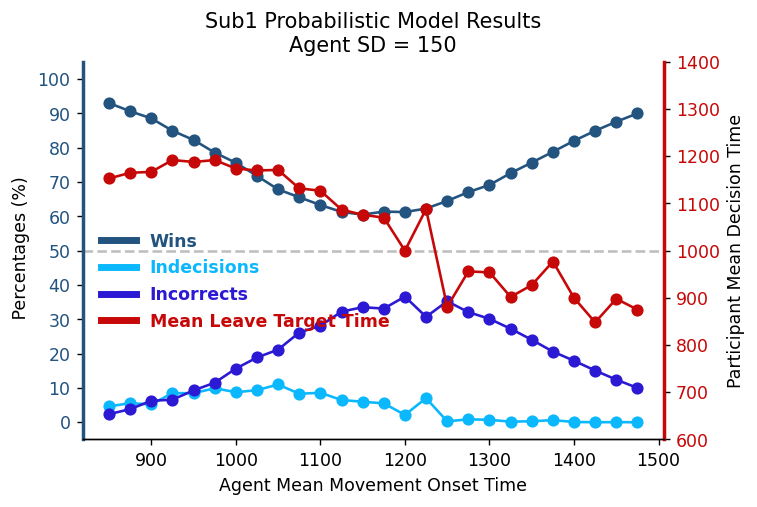

In [457]:
sim_50.plot_optimals_all_on_one(metrics_ax1=['Wins','Indecisions','Incorrects'],metrics_ax2=['Mean Leave Target Time'],save = False)